In [83]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import matplotlib.pyplot as plt
import torch
X = []
Y = []
data = []
labels = []

for i in range(-100,101):
  X.append(i/100)
  Y.append(i/100)

for i in range(201):
  for j in range(201):
    data.append([X[i],Y[j],1]) #we also add bias

random.shuffle(data)

for d in data:
  if d[0]>0.5 and d[1]>0.5:
    labels.append(1)
  else:
    labels.append(-1)


divide into train and test, 70% train and 30% test

In [84]:
train_set_x = []
train_set_y = []
test_set_x = []
test_set_y = []

In [85]:
divide_train_test = 0.7

for i in range(40401):
  if i < 40401*divide_train_test:
    train_set_x.append(data[i])
    train_set_y.append(labels[i])
  else:
    test_set_x.append(data[i])
    test_set_y.append(labels[i])

print(len(train_set_x))
print(len(test_set_x))

28281
12120


making data as tensor input

In [86]:
from torch.utils.data import DataLoader, TensorDataset
train_set_x = torch.tensor(train_set_x)
train_set_y = torch.tensor(train_set_y)
test_set_x = torch.tensor(test_set_x)
test_set_y = torch.tensor(test_set_y)

# making it tensor
train_set = DataLoader(TensorDataset(train_set_x, train_set_y.to(torch.float32)), batch_size=1)
test_set = DataLoader(TensorDataset(test_set_x, test_set_y.to(torch.float32)), batch_size=1)



In [87]:
def get_accuracy(test_loader, model):
    # calculate model accuracy
    accuracy = 0
    counter = 0
    for data, label in test_loader:
        features = model(data)
        pred_y = model.predict(features)
        # calculate the number of equal predicted labels and ground truth labels
        pred_y[pred_y > 0] = 1
        pred_y[pred_y <= 0] = -1
        for y, l in zip(pred_y, label):
            accuracy += int(y == l)
        counter += len(label)

    accuracy /= counter
    return accuracy

Neural network model

In [88]:
import torch.nn as nn

class NeuralNetwork(nn.Module):

    def __init__(self, layers, activation):
        super().__init__()
        self.net_dims = layers
        net_layers = []
        for layer in zip(self.net_dims[:-1], self.net_dims[1:]):
            in_size, out_size = layer
            net_layers += [
                nn.Linear(in_size, out_size, bias=True)
            ]
            net_layers += [
                torch.nn.ReLU()
            ]

        self.forward_layers = nn.Sequential(*net_layers[:-1])

    def forward(self, x, g_p=False):
        h = self.forward_layers[0](x)
        h = self.forward_layers[1](h)  # activation
        if g_p:
            geometric_plot(x, h, self.net_dims[1], "Layer 1")
        h = self.forward_layers[2](h)
        h = self.forward_layers[3](h)  # activation
        if g_p:
            geometric_plot(x, h, self.net_dims[2], "Layer 2")

        return h

    def predict(self, x, g_p=False, xy=None):
        prediction = self.forward_layers[-1](x)
        if g_p:
            geometric_plot(xy, prediction, self.net_dims[-1], "Output layer")

        return prediction


C. Train NN USING BACK PROPAGATION

In [89]:
from tabulate import tabulate
# tables to print
result_table = []
# define network
layers = [3, 4, 4, 1]
model = NeuralNetwork(layers, "relu")
mse_loss = torch.nn.MSELoss()
learning_rate = 0.001
epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for i in range(epochs):
  model.train()
  losses = []
  for input, desired in train_set:
      optimizer.zero_grad()
      # calculate output
      features = model(input)
      output = model.predict(features)
      # calculate loss
      output = output[:, 0]
      loss = mse_loss(output, desired)
      # backpropagation
      loss.backward()
      optimizer.step()
      losses.append(loss.detach())

  model.eval()
  mean_loss = np.mean(losses)
  train_acc = get_accuracy(train_set, model)
  print(f"epoch {i} | train acc : {train_acc}, train loss : {mean_loss} ")
  test_acc = get_accuracy(test_set, model)
  result_table.append([i, mean_loss, train_acc, test_acc])

print("Result table (train and test): ")
print(tabulate(result_table, headers=["Epoch", "Train loss", "Train accuracy", "Test accuracy"]))
test_acc = get_accuracy(test_set, model)

epoch 0 | train acc : 0.993812099996464, train loss : 0.09358719736337662 
epoch 1 | train acc : 0.9929281142816732, train loss : 0.024202032014727592 
epoch 2 | train acc : 0.9929634737102648, train loss : 0.01846926659345627 
epoch 3 | train acc : 0.9934585057105477, train loss : 0.01575646735727787 
epoch 4 | train acc : 0.9938828188536474, train loss : 0.01380190346390009 
Result table (train and test): 
  Epoch    Train loss    Train accuracy    Test accuracy
-------  ------------  ----------------  ---------------
      0     0.0935872          0.993812         0.993894
      1     0.024202           0.992928         0.993482
      2     0.0184693          0.992963         0.993069
      3     0.0157565          0.993459         0.993729
      4     0.0138019          0.993883         0.994472


plot **geomtric** diagram

In [90]:
import matplotlib.pyplot as plt

def geometric_plot(xy, data, num_n, layer):
  fig, axs = plt.subplots(num_n)
  print(data.shape)
  for i in range(num_n):
      if num_n == 1:
          idx = torch.where(data[:] > 0)
      else:
          idx = torch.where(data[:, i] > 0)

      if idx:
          idx = idx[0].to(dtype=torch.long)

          if num_n == 1:
              plt.scatter(xy[idx, 0], xy[idx, 1], color='r', label='Class 1')
          else:
              axs[i].scatter(xy[idx, 0], xy[idx, 1], color='r', label='Class 1')

      if num_n == 1:
          idx = torch.where(data[:] <= 0)
      else:
          idx = torch.where(data[:, i] <= 0)

      if idx:
          idx = idx[0].to(dtype=torch.long)

          if num_n == 1:
              plt.scatter(xy[idx, 0], xy[idx, 1], color='b', label='Class -1')
              plt.legend()
          else:
              axs[i].scatter(xy[idx, 0], xy[idx, 1], color='b', label='Class -1')
              axs[i].legend()
  if num_n == 1:   
    plt.title(layer)
    plt.show()
  else:
    fig.suptitle(layer)
    fig.show()

plot **geomtric** diagram

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([28281, 4])
torch.Size([28281, 4])


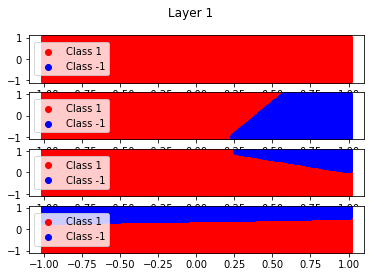

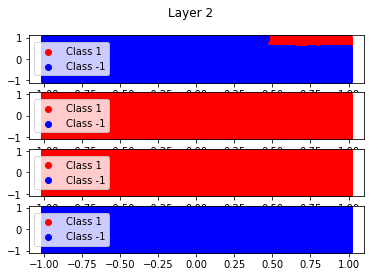

In [91]:
new_train_x = model.forward(torch.tensor(train_set_x).to(torch.float32), g_p=True).detach().numpy()

torch.Size([28281, 1])


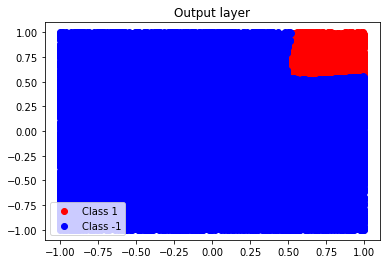

tensor([[-0.9968],
        [ 1.0526],
        [ 1.0589],
        ...,
        [-0.9988],
        [-1.0022],
        [-1.0029]], grad_fn=<AddmmBackward>)

In [92]:
model.predict(torch.tensor(new_train_x), g_p=True, xy=train_set_x)

D. Train adaline on trained network

In [93]:
Errors = []
# use Net last layer as input
(number_of_rows, number_of_cols) = new_train_x.shape
np.random.seed(1)
# we initiate weights with random values
W = np.random.random((number_of_cols,))-1
lr = 0.0001
for iter in range(2):
  for input,desired in zip(new_train_x, train_set_y):

    adaline_output = 0
    for i in range(len(W)):
      adaline_output += input[i]*W[i]

    if adaline_output > 0 :
      adaline_output = 1
    else:
      adaline_output = -1

    Error = desired - adaline_output
    Errors.append(Error)

    for i in range(1, len(W)):
      W[i] = W[i] + lr*Error*input[i]


predict

In [94]:
new_test_x = model.forward(torch.tensor(test_set_x).to(torch.float32)).detach().numpy()
(number_of_rows, number_of_cols) = new_test_x.shape
predicted_y = np.arange(number_of_rows)
predicts = []

for i in range(number_of_rows):
  if np.dot(W, new_test_x[i]) > 0:
    predicted_y[i] = 1
    predicts.append(1)
  else:
    predicted_y[i] = -1
    predicts.append(-1)

predicted_y = np.array(predicted_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


show the error graph

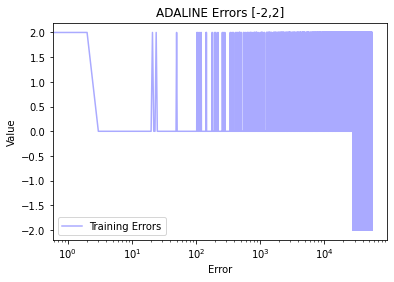

In [95]:
ax = plt.subplot(111)
ax.plot(Errors, c='#aaaaff', label='Training Errors')
ax.set_xscale("log")
plt.title("ADALINE Errors [-2,2]")
plt.legend()
plt.xlabel('Error')
plt.ylabel('Value')
plt.show()

See if the predictions graph and Real labels graph looks similar

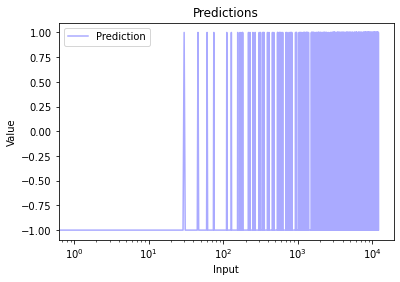

In [96]:
ax = plt.subplot(111)
ax.plot(predicts, c='#aaaaff', label='Prediction')
ax.set_xscale("log")
plt.title("Predictions")
plt.legend()
plt.xlabel('Input')
plt.ylabel('Value')
plt.show()

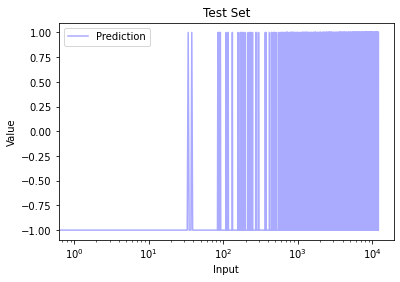

In [97]:
ax = plt.subplot(111)
ax.plot(test_set_y, c='#aaaaff', label='Prediction')
ax.set_xscale("log")
plt.title("Test Set")
plt.legend()
plt.xlabel('Input')
plt.ylabel('Value')
plt.show()

Where all points of the prediction should be (in the right up corner).

(-1.0, 1.0)

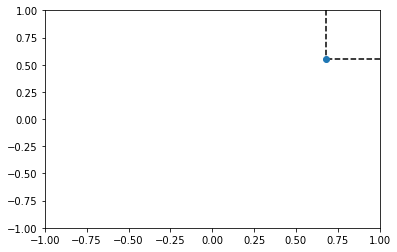

In [98]:
show_test = []
for i in test_set_x:
  if i[0] >0.5 and i[1] > 0.5:
    show_test.append(i)
plt.vlines(min(show_test[0]),1,min(show_test[1]),linestyle="dashed")
plt.hlines(min(show_test[1]),1,min(show_test[0]),linestyle="dashed")
plt.scatter(min(show_test[0]), min(show_test[1]), zorder=2)
plt.xlim([-1,1])
plt.ylim([-1,1])

See how good is our model for this problem

In [99]:
c=0
for i in range(len(test_set_y)):
  if predicts[i] == test_set_y[i]:
    c+=1
c = c/len(test_set_y)
print ("the model has %s success rate" %c)

the model has 0.902970297029703 success rate


In [111]:
X = []
Y = []
data = []
labels = []

for i in range(-100,101):
  X.append(i/100)
  Y.append(i/100)

for i in range(201):
  for j in range(201):
    data.append([X[i],Y[j],1]) #we also add bias

random.shuffle(data)

for d in data:
  if d[0]**2 + d[1]**2 >= 1/2 and d[0]**2 + d[1]**2 <= 3/4:
    labels.append(1)
  else:
    labels.append(-1)

train_set_x = []
train_set_y = []
test_set_x = []
test_set_y = []

divide_train_test = 0.7

for i in range(40401):
  if i < 40401*divide_train_test:
    train_set_x.append(data[i])
    train_set_y.append(labels[i])
  else:
    test_set_x.append(data[i])
    test_set_y.append(labels[i])

from torch.utils.data import DataLoader, TensorDataset
train_set_x = torch.tensor(train_set_x)
train_set_y = torch.tensor(train_set_y)
test_set_x = torch.tensor(test_set_x)
test_set_y = torch.tensor(test_set_y)

# making it tensor
train_set = DataLoader(TensorDataset(train_set_x, train_set_y.to(torch.float32)), batch_size=1)
test_set = DataLoader(TensorDataset(test_set_x, test_set_y.to(torch.float32)), batch_size=1)


In [150]:
# tables to print
result_table = []
# define network
layers = [3, 12, 16, 1]
model = NeuralNetwork(layers, "relu")
mse_loss = torch.nn.MSELoss()
learning_rate = 0.002
epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for i in range(epochs):
  model.train()
  losses = []
  for input, desired in train_set:
      optimizer.zero_grad()
      # calculate output
      features = model(input)
      output = model.predict(features)
      # calculate loss
      output = output[:, 0]
      loss = mse_loss(output, desired)
      # backpropagation
      loss.backward()
      optimizer.step()
      losses.append(loss.detach())

  model.eval()
  mean_loss = np.mean(losses)
  train_acc = get_accuracy(train_set, model)
  print(f"epoch {i} | train acc : {train_acc}, train loss : {mean_loss} ")
  test_acc = get_accuracy(test_set, model)
  result_table.append([i, mean_loss, train_acc, test_acc])

print("Result table (train and test): ")
print(tabulate(result_table, headers=["Epoch", "Train loss", "Train accuracy", "Test accuracy"]))
test_acc = get_accuracy(test_set, model)

epoch 0 | train acc : 0.8109331353205332, train loss : 0.5656611919403076 
epoch 1 | train acc : 0.9328878045330787, train loss : 0.37442678213119507 
epoch 2 | train acc : 0.9445917753969096, train loss : 0.20023395121097565 
epoch 3 | train acc : 0.9400304091085888, train loss : 0.1408756971359253 
epoch 4 | train acc : 0.9541741805452424, train loss : 0.12159905582666397 
Result table (train and test): 
  Epoch    Train loss    Train accuracy    Test accuracy
-------  ------------  ----------------  ---------------
      0      0.565661          0.810933         0.810314
      1      0.374427          0.932888         0.933416
      2      0.200234          0.944592         0.944802
      3      0.140876          0.94003          0.939769
      4      0.121599          0.954174         0.957096


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([28281, 12])
torch.Size([28281, 16])


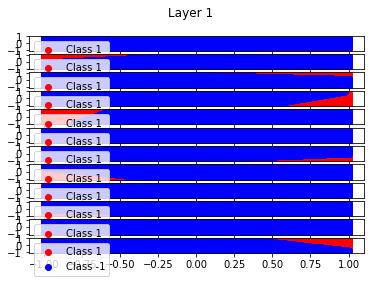

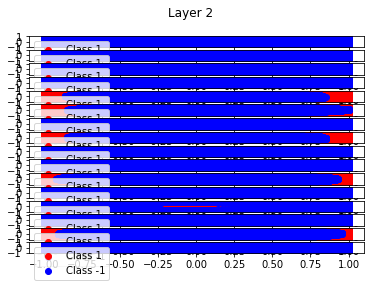

In [151]:
new_train_x = model.forward(torch.tensor(train_set_x).to(torch.float32), g_p=True).detach().numpy()

torch.Size([28281, 1])


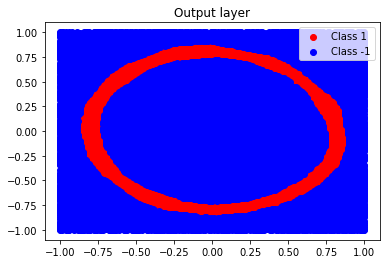

tensor([[-0.5812],
        [ 0.9706],
        [-1.0885],
        ...,
        [-1.0885],
        [-0.9629],
        [-1.0885]], grad_fn=<AddmmBackward>)

In [152]:
model.predict(torch.tensor(new_train_x), g_p=True, xy=train_set_x)

In [153]:
Errors = []
# use Net last layer as input
(number_of_rows, number_of_cols) = new_train_x.shape
np.random.seed(1)
# we initiate weights with random values
W = np.random.random((number_of_cols,))-1
lr = 0.00001
for iter in range(5):
  for input,desired in zip(new_train_x, train_set_y):

    adaline_output = 0
    for i in range(number_of_cols):
      adaline_output += input[i]*W[i]

    if adaline_output > 0 :
      adaline_output = 1
    else:
      adaline_output = -1

    Error = desired - adaline_output
    Errors.append(Error)

    for i in range(1, len(W)):
      W[i] = W[i] + lr*Error*input[i]

print("Adaline finish trainig")

Adaline finish trainig


In [162]:
new_test_x = model.forward(torch.tensor(test_set_x).to(torch.float32)).detach().numpy()
(number_of_rows, number_of_cols) = new_test_x.shape
# test_set_x = np.c_[test_set_x,np.ones(number_of_rows)]
predicted_y = np.zeros(number_of_rows)
predicts = []

for i in range(number_of_rows):
  adaline_output = 0
  for j in range(number_of_cols):
    adaline_output += new_test_x[i,j]*W[j]
  print(adaline_output)
  if adaline_output >= 0:
    predicted_y[i] = 1
    predicts.append(1)
  else:
    predicted_y[i] = -1
    predicts.append(-1)

predicted_y = np.array(predicted_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


Streaming output truncated to the last 5000 lines.
-0.2972402518166426
0.0
-0.3789840504430124
-1.4587060211591947
-0.1385900927482311
-0.3789840504430124
-0.17316579444904434
-0.3789840504430124
-0.7003312093726954
-0.3789840504430124
-1.2809311884081964
-2.4552707886968363
-10.68194562068193
0.0
-0.3789840504430124
-4.38392334663185
-4.835647519949802
-0.3789840504430124
-1.5659146973211406
-0.3789840504430124
-9.510103880294665
-2.1310857340597877
-0.03760388427550154
-7.254702989810603
-0.2514702920378511
-3.2714865712073653
-0.3789840504430124
-5.311208174286367
-3.071960737159756
-2.8286871084463385
-0.3789840504430124
-0.3789840504430124
0.0
-5.6936594558167215
-0.3789840504430124
-3.0757954696065504
-0.3789840504430124
-1.6754881421973877
-4.276050392650291
-0.3789840504430124
-0.7184488095781454
0.0
0.0
0.0
-0.3789840504430124
-0.3789840504430124
-0.3789840504430124
-0.9115290239077822
-0.3789840504430124
-0.16109907478991659
-0.30571140832065424
0.0
-0.3789840504430124
-0.378

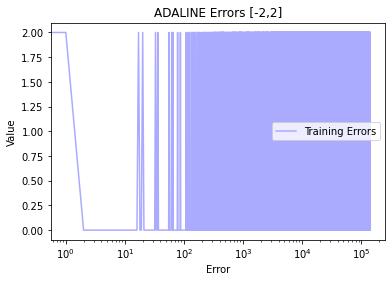

In [163]:
ax = plt.subplot(111)
ax.plot(Errors, c='#aaaaff', label='Training Errors')
ax.set_xscale("log")
plt.title("ADALINE Errors [-2,2]")
plt.legend()
plt.xlabel('Error')
plt.ylabel('Value')
plt.show()

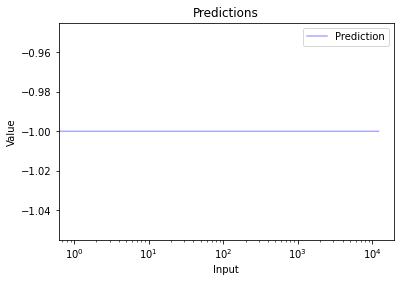

In [157]:
ax = plt.subplot(111)
ax.plot(predicts, c='#aaaaff', label='Prediction')
ax.set_xscale("log")
plt.title("Predictions")
plt.legend()
plt.xlabel('Input')
plt.ylabel('Value')
plt.show()

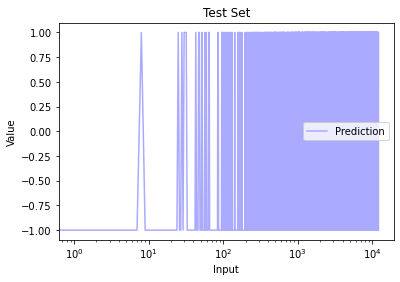

In [158]:
ax = plt.subplot(111)
ax.plot(test_set_y, c='#aaaaff', label='Prediction')
ax.set_xscale("log")
plt.title("Test Set")
plt.legend()
plt.xlabel('Input')
plt.ylabel('Value')
plt.show()

(-1.0, 1.0)

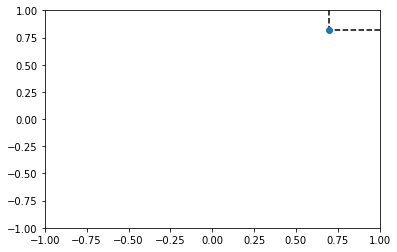

In [159]:
show_test = []
for i in test_set_x:
  if i[0] >0.5 and i[1] > 0.5:
    show_test.append(i)
plt.vlines(min(show_test[0]),1,min(show_test[1]),linestyle="dashed")
plt.hlines(min(show_test[1]),1,min(show_test[0]),linestyle="dashed")
plt.scatter(min(show_test[0]), min(show_test[1]), zorder=2)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [164]:
c=0
for i in range(len(test_set_y)):
  if predicts[i] == test_set_y[i]:
    c+=1
    
c = c/len(test_set_y)
print ("the model has %s success rate" %c)

the model has 0.9165841584158416 success rate


**Summary:**

From the results that we showed, we can conclude that Adaline alone is not very accuracte and that backpropagation can lead to better results, but, Adaline can be very accurate and lead to good results when combined with backpropagation.
The major difference in the results relative to sections A and B is that the training input for Adaline, in this case, was in a higher dimension which better represents the data. When dealing with almost linearly separable data, Adaline results improve dramatically.

We can see from the above diagrams and results that after the neural network found a better representation of the data, the accuracy of Adaline increase significantly. Thus, Adaline can act as a classifier when used with a small enough learning rate to avoid over-fitting.

Also, we can conclude that using backpropagation in the learning process can bring significant improvement to the training process relative to Adaline.
